### Import libraries

In [1]:
import os
import sys

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

from xgboost import XGBClassifier

# import own modules
sys.path.append(os.path.join("..", ".."))
from scripts import preprocessing as pp
from scripts import evaluate_models as em

plt.style.use(
    "https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle"
)

---
## Preparations

### Load the CSV into a Dataframe

- load csv (or calculate again if not in data folder)
- update index=id
- drop useless columns
- find numerical & object columns

In [2]:
# path to csv file
path_df = os.path.join("..", "..", "data", "df_deep_sam.csv")

# get features
df = pd.read_csv(path_df)

# set id as index
df = df.set_index("id", drop=True)

# drop first batch of useless variables
df = df.drop(columns=["img", "sp_idx"])
df = df.drop(columns=[col for col in df.columns if "_obj" in col])
df = df.drop(columns=[col for col in df.columns if "sam_sal_" in col])

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7598 instances and 34 columns
 -> there are 34 numerical columns
 -> there are 0 categoricals columns


### First, drop instances & features

- unusual long fixation durations are identified as outliers and dropped
  - drop if "dur > 5000 ms"
- drop `sal_first_above_0.75*max_rank` & `sal_first_above_0.9*max_rank` since this features consists of mainly (33% / 61%) outlier values
  - outliers are coded as "20" 


In [3]:
# processing
df = df[df["sp_fix_duration_ms_total"] <= 5000]
df = df.drop(
    columns=["dg_sal_first_above_0.75*max_rank", "dg_sal_first_above_0.9*max_rank"]
)

# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

 -> dataframe has 7217 instances and 32 columns
 -> there are 32 numerical columns
 -> there are 0 categoricals columns


### Checking for highly correlated columns
think after running this lines, which column to additionally drop

Correlation between sp_fix_duration_ms_total and dg_sal_weighted_duration_sum is 0.828
Correlation between sp_fix_duration_ms_mean and dg_sal_weighted_duration_mean is 0.815
Correlation between obj_n_fix_face and obj_t_abs_on_face is 0.822
Correlation between obj_n_fix_face and obj_t_rel_on_face is 0.801
Correlation between obj_n_fix_inanimate and obj_t_abs_on_inanimate is 0.868
Correlation between obj_n_fix_inanimate and obj_t_rel_on_inanimate is 0.841
Correlation between obj_n_fix_background and obj_t_abs_on_background is 0.84
Correlation between obj_n_fix_background and obj_t_rel_on_background is 0.804


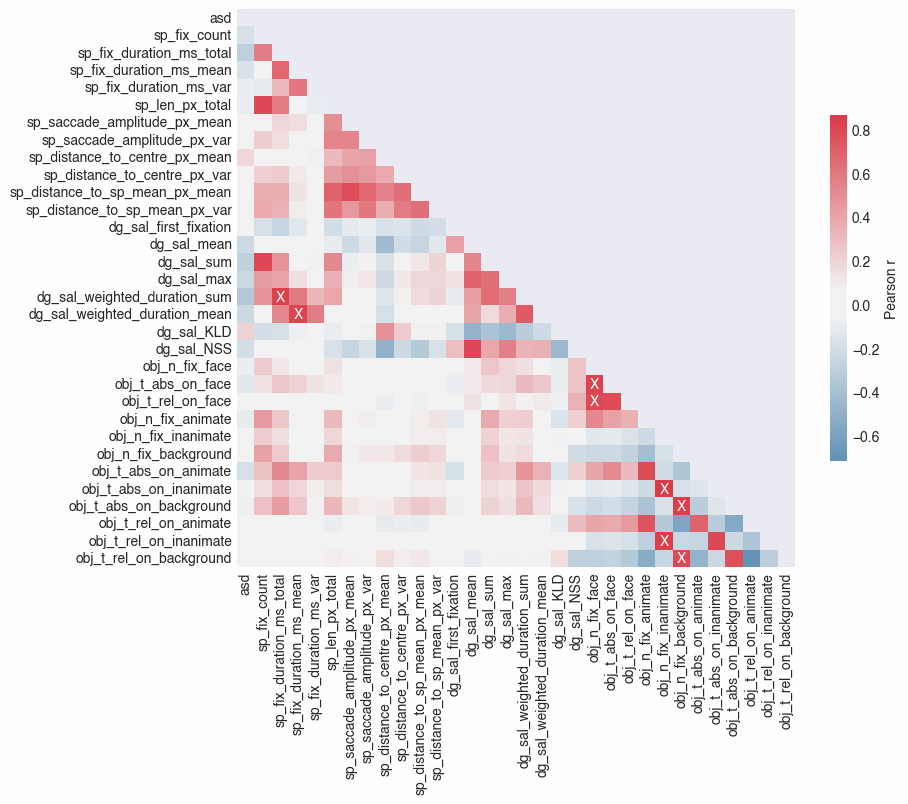

In [4]:
# check for correlations
pp.check_correlations(df[num_cols], thresh=0.8)

### further processing of correlating features
- `sp_fix_duration_ms_total` & `sp_fix_duration_ms_mean`
  - keep the `saliency weighted` version of both fixation duration measures
- `obj_n_fix_*`
  - keep the time measures of object recognition features

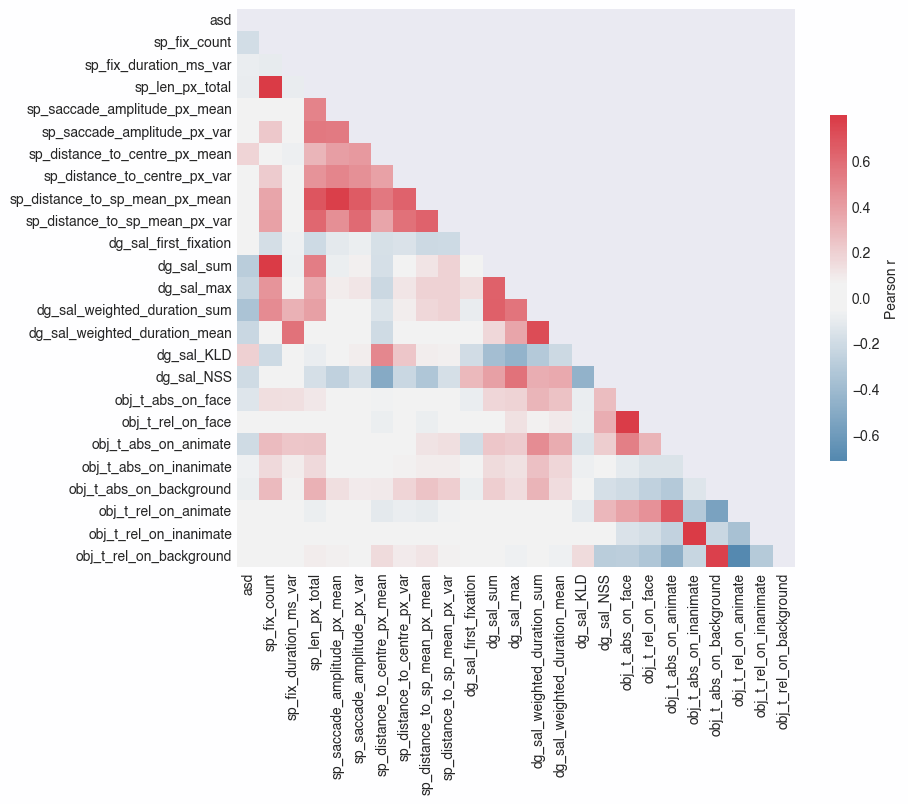

 -> dataframe has 7217 instances and 25 columns
 -> there are 25 numerical columns
 -> there are 0 categoricals columns


In [5]:
# processing
df = df.drop(
    columns=[
        "sp_fix_duration_ms_total",
        "sp_fix_duration_ms_mean",
        "obj_n_fix_face",
        "obj_n_fix_animate",
        "obj_n_fix_inanimate",
        "obj_n_fix_background",
        "dg_sal_mean",
    ]
)
# find numerical and categorical columns
num_cols = df.columns[df.dtypes != "object"]
cat_cols = df.columns[df.dtypes == "object"]

# check for correlations, again
pp.check_correlations(df[num_cols], thresh=0.8)

# print info
print(f" -> dataframe has {df.shape[0]} instances and {df.shape[1]} columns")
print(f" -> there are {len(num_cols)} numerical columns")
print(f" -> there are {len(cat_cols)} categoricals columns")

### Split into train & test sets

As soon as the dataset is in its final form, perform train-test-split with our own split function to have out 30-image-set always as our test set.

In [6]:
# prepare features and target
X = df
y = X.pop("asd")

# define numerical columns once more
num_cols = X.columns[X.dtypes != "object"]

# train-test-split
X_train, X_test, y_train, y_test = pp.split(X, y)

# print info
print(f"train-set has '{len(y_train)}' samples & '{X.shape[1]}' features")
print(f"test-set has '{len(y_test)}' samples - out of '{df.shape[0]}'")
print(f"  ~ {len(y_test) / df.shape[0] * 100:.2f}% of full dataset")

train-set has '6485' samples & '24' features
test-set has '732' samples - out of '7217'
  ~ 10.14% of full dataset


### Set variables

- define `metric`
- behavior for saving models as pickles
- defaults for model-objects

In [7]:
# metric
ftwo_scorer = make_scorer(fbeta_score, beta=2)

# defaults
RSEED = 42
cv = 10
n_jobs = -1
verbose = 1

# Modeling preparation

In [8]:
# add other transformations at the end if needed
transformer = [
    ("scaler", MinMaxScaler(), num_cols),
    ("ohe", OneHotEncoder(drop="first"), cat_cols),
]

preprocessing = ColumnTransformer(transformer, remainder="passthrough")

### Pipeline

In [9]:
# XGBoost: apply scaling / encoding
xgb_pipeline = Pipeline(
    [("preprocessor", preprocessing), ("classifier", XGBClassifier())]
)

### Parameter grid

In [10]:
# XGBoost
param_grid_xgb = {
    "classifier__n_estimators": [100, 200, 300],
    "classifier__max_depth": [3, 5, 7, None],
    "classifier__learning_rate": [0.1, 0.01, 0.001],
}

In [11]:
# Create GridSearchCV object
grid_search_xgb = GridSearchCV(
    xgb_pipeline,
    param_grid=param_grid_xgb,
    cv=cv,
    scoring=ftwo_scorer,
    n_jobs=n_jobs,
    verbose=verbose,
    error_score="raise",
)
grid_search_xgb.fit(X_train, y_train)

# Get the best parameters and best estimator
best_params_xgb = grid_search_xgb.best_params_
best_est_xgb = grid_search_xgb.best_estimator_
print("Best params for XGB are:", best_params_xgb)
print("Best est for XGB are:", best_est_xgb)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
Best params for XGB are: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 5, 'classifier__n_estimators': 100}
Best est for XGB are: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  Index(['sp_fix_count', 'sp_fix_duration_ms_var', 'sp_len_px_total',
       'sp_saccade_amplitude_px_mean', 'sp_saccade_amplitude_px_var',
       'sp_distance_to_centre_px_mean', 'sp_distance_to_centre_px_var',
       'sp_distance_to_sp_mean_px_mean', 'sp_distance_to...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                    

Best params for XGB are: {'classifier__learning_rate': 0.01, 'classifier__max_depth': None, 'classifier__n_estimators': 200}
Best est for XGB are: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('scaler', MinMaxScaler(),
                                                  Index(['sp_fix_count', 'sp_fix_duration_ms_var', 'sp_len_px_total',
       'sp_saccade_amplitude_px_mean', 'sp_saccade_amplitude_px_var',
       'sp_distance_to_centre_px_mean', 'sp_distance_to_centre_px_var',
       'sp_distance_to_sp_mean_px_mean', 'sp_distance_to...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [12]:
# predict & proba
pred_test = grid_search_xgb.predict(X_test)
proba_test = grid_search_xgb.predict_proba(X_test)

pred_train = grid_search_xgb.predict(X_train)
proba_train = grid_search_xgb.predict_proba(X_train)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.734     0.715     0.724      3252
           1      0.720     0.739     0.729      3233

    accuracy                          0.727      6485
   macro avg      0.727     0.727     0.727      6485
weighted avg      0.727     0.727     0.727      6485

f(0.5)-score: 0.724
f(2.0)-score: 0.735

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.698     0.709     0.703       371
           1      0.696     0.684     0.690       361

    accuracy                          0.697       732
   macro avg      0.697     0.697     0.697       732
weighted avg      0.697     0.697     0.697       732

f(0.5)-score: 0.693
f(2.0)-score: 0.686



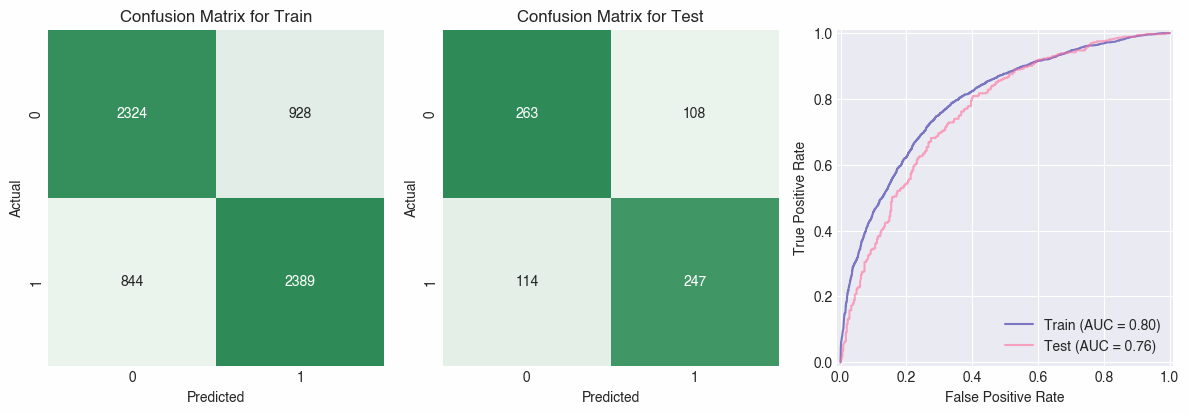

In [13]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

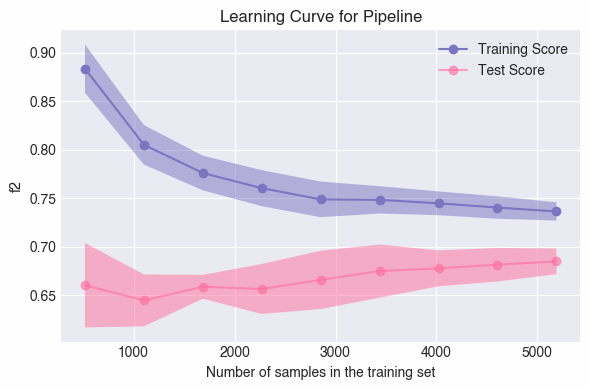

In [14]:
# learning curves - for one model - f2 score
em.learning(best_est_xgb, X_train, y_train)

### Feature importance using permutation importance 

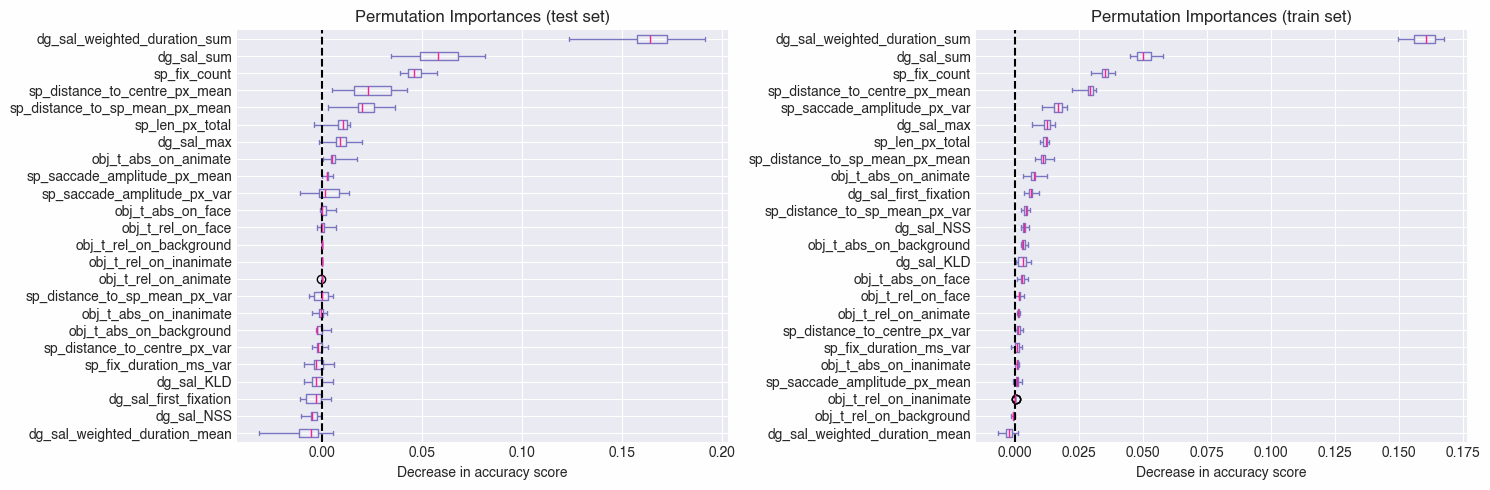

In [15]:
#calculate permutation importance for test data 
result_test = permutation_importance(
    grid_search_xgb, X_test, y_test, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    grid_search_xgb, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(15,5))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()

remove: sal_mean, sal_weighted_duration_mean, sal_first_fixation, sp_saccade_amplitude_px_var, sp_distance_to_centre_px_var

### Trying to fine-tune hyperparamters

In [16]:

xgb= Pipeline(steps=[
    ('preprocessor', MinMaxScaler()),  
    ('classifier', XGBClassifier(learning_rate=0.01, max_depth=5, n_estimators=100, reg_lambda=3))
])

# Fit the pipeline to your data
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor', MinMaxScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.01,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [17]:
# predict & proba
pred_test = xgb.predict(X_test)
proba_test = xgb.predict_proba(X_test)

pred_train = xgb.predict(X_train)
proba_train = xgb.predict_proba(X_train)

-------------------- classification report for 'Train' --------------------
              precision    recall  f1-score   support

           0      0.732     0.711     0.721      3252
           1      0.717     0.738     0.727      3233

    accuracy                          0.724      6485
   macro avg      0.724     0.724     0.724      6485
weighted avg      0.724     0.724     0.724      6485

f(0.5)-score: 0.721
f(2.0)-score: 0.734

-------------------- classification report for 'Test' --------------------
              precision    recall  f1-score   support

           0      0.694     0.704     0.699       371
           1      0.691     0.681     0.686       361

    accuracy                          0.693       732
   macro avg      0.693     0.692     0.692       732
weighted avg      0.693     0.693     0.693       732

f(0.5)-score: 0.689
f(2.0)-score: 0.683



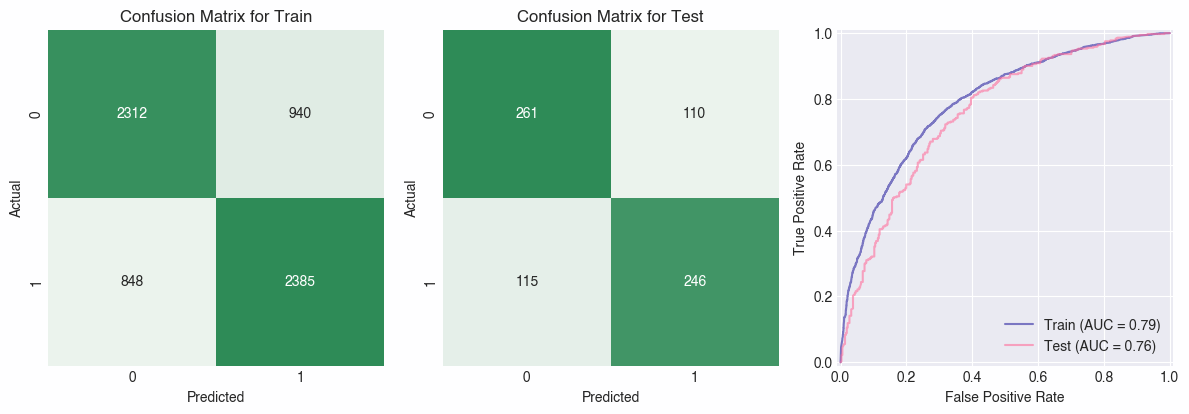

In [18]:
# evaluate model
em.report(
    y_train=y_train,
    y_train_pred=pred_train,
    y_train_proba=proba_train,
    y_test=y_test,
    y_test_pred=pred_test,
    y_test_proba=proba_test,
)

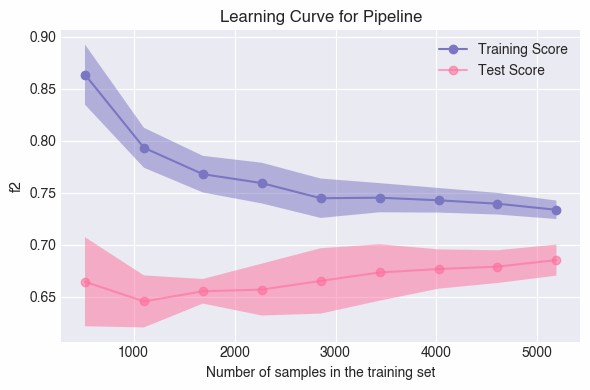

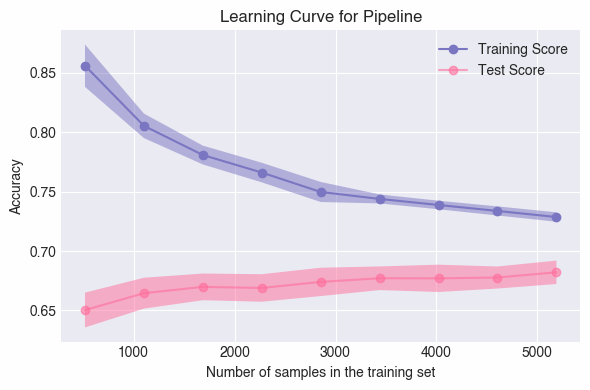

In [19]:
# learning curves - for one model - default score = f2
em.learning(xgb, X_train, y_train)

# learning curves - for one model - accuracy score
em.learning(xgb, X_train, y_train, score='accuracy', score_name="Accuracy")

30it [00:25,  1.18it/s]


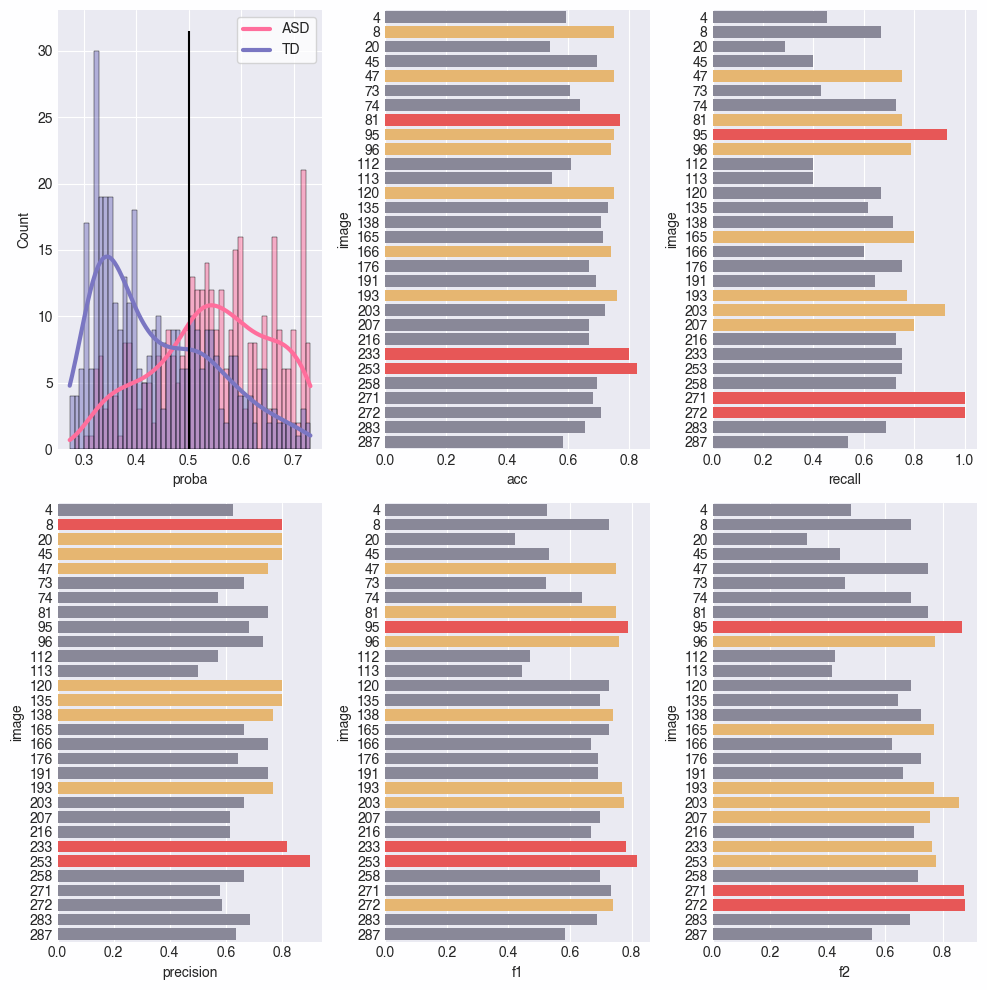

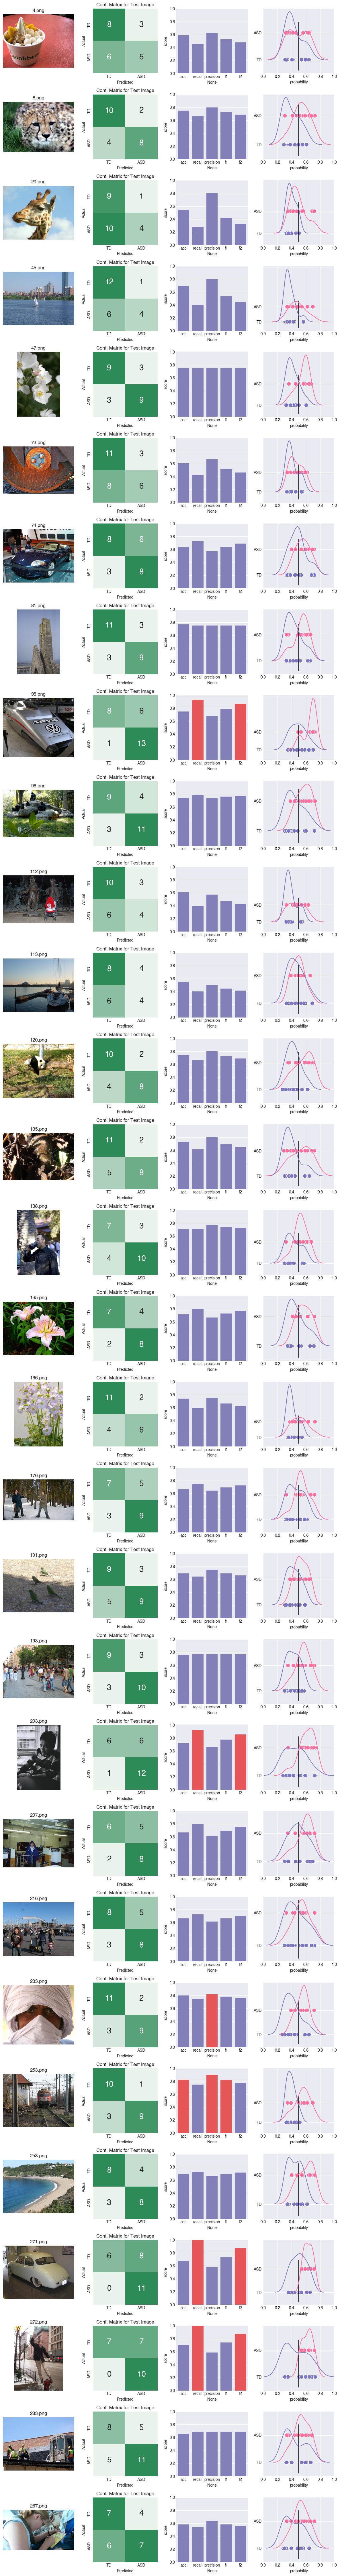

In [20]:
em.error_images(y_test, pred_test, proba_test)

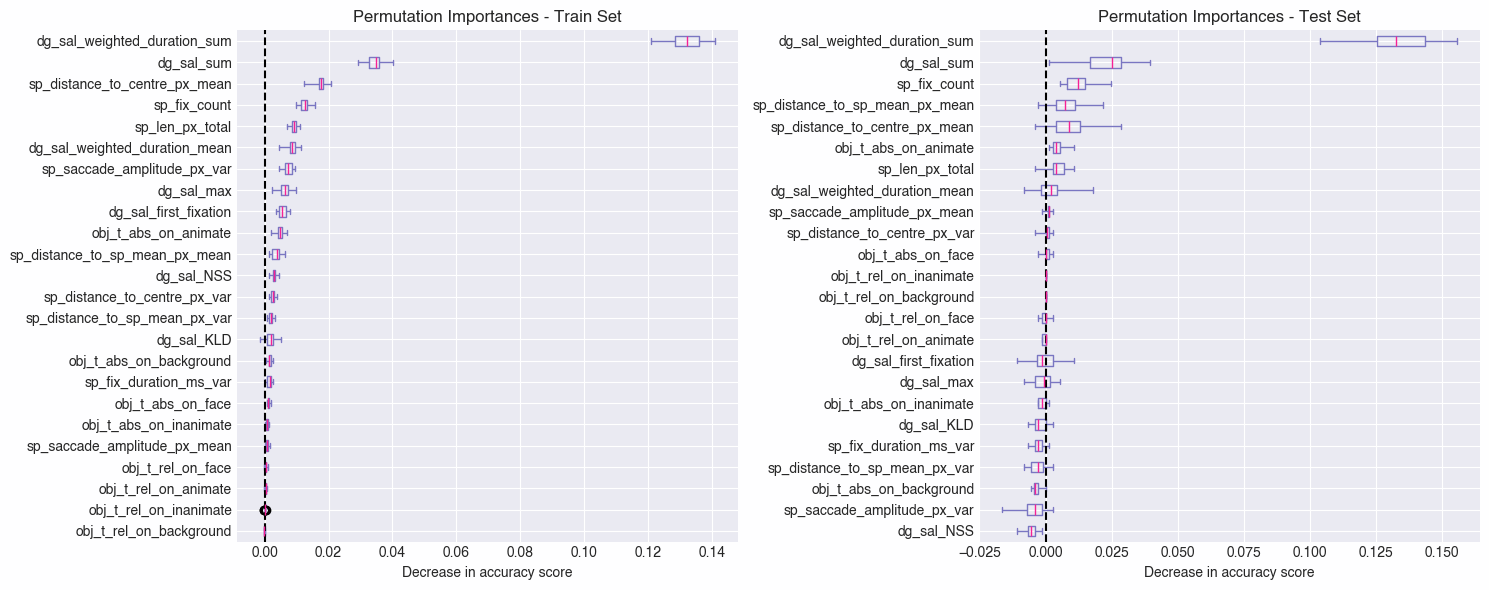

In [21]:
em.feat_importance(xgb, X_train, y_train, X_test, y_test)

#### Saving the model

In [22]:
# save model
model_folder = os.path.join("..", "..", "models", "dev", "XGB")
model_name = "XGB_depth_5.pickle"
em.save_model(xgb, model_name, folder=model_folder)

 -> model saved in: '../../models/dev/XGB/XGB_depth_5_1.pickle'
